# ✌️ Affine 계층을 추가한 TwoLayerNet 학습시키기

### 📥 Import

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Thanks to **dhaitz**!
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# 한글폰트 설정
import matplotlib as mpl
mpl.rc('font', family='D2Coding')
mpl.rcParams['axes.unicode_minus'] = False

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
print(f'현재 작업 디렉토리: "{os.getcwd()}"')

from common.functions import *
from common.gradient import numerical_gradient
from common.layers import *
from dataset.mnist import load_mnist

현재 작업 디렉토리: "g:\zer0ken\ms-ai-school\neural-net\ch04 오차역전파법"


### 🧵 신경망

In [8]:
class TwoLayerNet:
    def __init__(self, input_size=784, hidden_size=50, output_size=10, std=0.01):
        self.params = {
            'W1': std * np.random.randn(input_size, hidden_size),
            'b1': np.zeros(hidden_size),
            'W2': std * np.random.randn(hidden_size, output_size),
            'b2': np.zeros(output_size),
        }
        
        self.layers = {
            'Affine 1': Affine(self.params['W1'], self.params['b1']),
            'ReLU 1': Relu(),
            'Affine 2': Affine(self.params['W2'], self.params['b2'])
        }
        self.output_layer = SoftmaxWithLoss()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, y_true):
        y_pred = self.predict(x)
        return self.output_layer.forward(y_pred, y_true)
    
    def accuracy(self, x, y_true):
        y_pred = self.predict(x)
        y_pred = np.argmax(y_pred, axis=1)
        
        if y_true.ndim != 1:
            y_true = np.argmax(y_true, axis=1)
        
        accuracy = np.sum(y_pred == y_true) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, y_true):
        loss_W = lambda W: self.loss(x, y_true)
        
        grads = {
            'W1': numerical_gradient(loss_W, self.params['W1']),
            'b1': numerical_gradient(loss_W, self.params['b1']),
            'W2': numerical_gradient(loss_W, self.params['W2']),
            'b2': numerical_gradient(loss_W, self.params['b2'])
        }
        return grads

    def gradient(self, x, y_true):
        self.loss(x, y_true)
        
        dout = 1
        dout = self.output_layer.backward(dout)
        for layer in list(self.layers.values())[::-1]:
            dout = layer.backward(dout)
        
        grads = {
            'W1': self.layers['Affine 1'].dW,
            'b1': self.layers['Affine 1'].db,
            'W2': self.layers['Affine 2'].dW,
            'b2': self.layers['Affine 2'].db
        }
        return grads

### ✍️ MNIST 데이터셋으로 학습

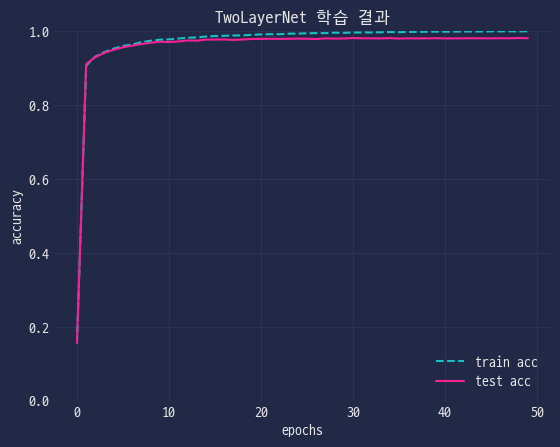

In [10]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

iters_num = 30000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
hidden_size = 350

network = TwoLayerNet(hidden_size=hidden_size)

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
last_test_acc = 0.0

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network. loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f'#{i:-6d} | {train_acc=:.6f} | test_acc= {last_test_acc:.6f} >>> {test_acc:.6f}', end='\r')
        last_test_acc = test_acc

x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc', linestyle='--')
plt.plot(x, test_acc_list, label='test acc',)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title('TwoLayerNet 학습 결과')
plt.show()